### Installing required libraries

In [ ]:
pip install neuralforecast==1.7.4 numpy==1.24.4  scikit-learn==1.3.2 matplotlib==3.7.1 pandas==2.1.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.4/249.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successful

Importing libraries

In [ ]:
import numpy as np
import pandas as pd
#import pytorch_lightning as pl
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import iTransformer
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss,MSE
from neuralforecast.tsdataset import TimeSeriesDataset
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

Create calculate error metrics function which helps in assessing the performance of the trained model

In [ ]:

def calculate_error_metrics(actual, predicted, num_predictors=1):
    # convert inputs are numpy arrays
    actual = np.array(actual)
    predicted = np.array(predicted)
    # Number of observations
    n = len(actual)
    # Calculate MSE
    mse = mean_squared_error(actual, predicted)
    # Calculate RMSE
    rmse = np.sqrt(mse)
    # Calculate MAPE
    mape = mean_absolute_percentage_error(actual, predicted)
    # Calculate R-squared
    r2 = r2_score(actual, predicted)
    # Calculate Adjusted R-squared
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - num_predictors - 1))
    print(f'MSE : {mse}')
    print(f'RMSE : {rmse}')
    print(f'MAPE : {mape}')
    print(f'r2 : {r2}')
    print(f'adjusted_r2 : {adjusted_r2}')

Load **AirPassenger** data set and Split data into **train** and **test**

In [ ]:
from neuralforecast.utils import AirPassengersDF as Y_df
# To load local csv  > modify to the right path where the file is present
#Y_df = pd.read_csv('AirPassengersDataset.csv')
#Y_df = Y_df.reset_index(drop=True)
#Y_df.head()

Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train
Y_test_df = Y_df[Y_df.ds>'1959-12-31']   # 12 test
dataset, *_ = TimeSeriesDataset.from_df(Y_train_df)

In [ ]:
Y_df.head()

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0


Lets initialize and training model (**iTransformer**) and define its hyperparameters.

In [ ]:
horizon =12
model =  iTransformer(h=horizon,
                     input_size=24,
                     n_series=2,
                     hidden_size=128,
                     n_heads=2,
                     e_layers=2,
                     d_layers=1,
                     d_ff=4,
                     factor=1,
                     dropout=0.1,
                     use_norm=True,
                     loss=MSE(),
                     valid_loss=MSE(),
                     #early_stop_patience_steps=2,
                     batch_size=32)
model.fit(dataset=dataset,val_size=12)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MSE                    | 0      | train
1 | valid_loss    | MSE                    | 0      | train
2 | padder        | ConstantPad1d          | 0      | train
3 | scaler        | TemporalNorm           | 0      | train
4 | enc_embedding | DataEmbedding_inverted | 3.2 K  | train
5 | encoder       | TransEncoder           | 135 K  | train
6 | projector     | Linear                 | 1.5 K  | train
-----------------------------------------------------------------
140 K     Trainable params
0         Non-trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


iTransformer

Predict for the next defined horizon

In [ ]:
y_hat = model.predict(dataset=dataset)
Y_test_df['iTransformers'] = y_hat

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<ipython-input-9-8ba246c52b64>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_test_df['iTransformers'] = y_hat


In [ ]:
Y_test_df

,unique_id,ds,y,iTransformers
132,1.0,1960-01-31,417.0,425.598022
133,1.0,1960-02-29,391.0,390.221741
134,1.0,1960-03-31,419.0,435.384155
135,1.0,1960-04-30,461.0,423.194702
136,1.0,1960-05-31,472.0,460.768036
137,1.0,1960-06-30,535.0,545.585083
138,1.0,1960-07-31,622.0,623.096680
139,1.0,1960-08-31,606.0,638.329468
140,1.0,1960-09-30,508.0,514.236145
141,1.0,1960-10-31,461.0,438.161316


Measure the models accuracy

In [ ]:
calculate_error_metrics(Y_test_df[['y']],Y_test_df['iTransformers'])

MSE : 335.6207580566406
RMSE : 18.319955825805664
MAPE : 0.030659830197691917
r2 : 0.9394128604587846
adjusted_r2 : 0.9333541465046631


Visualize the predictions

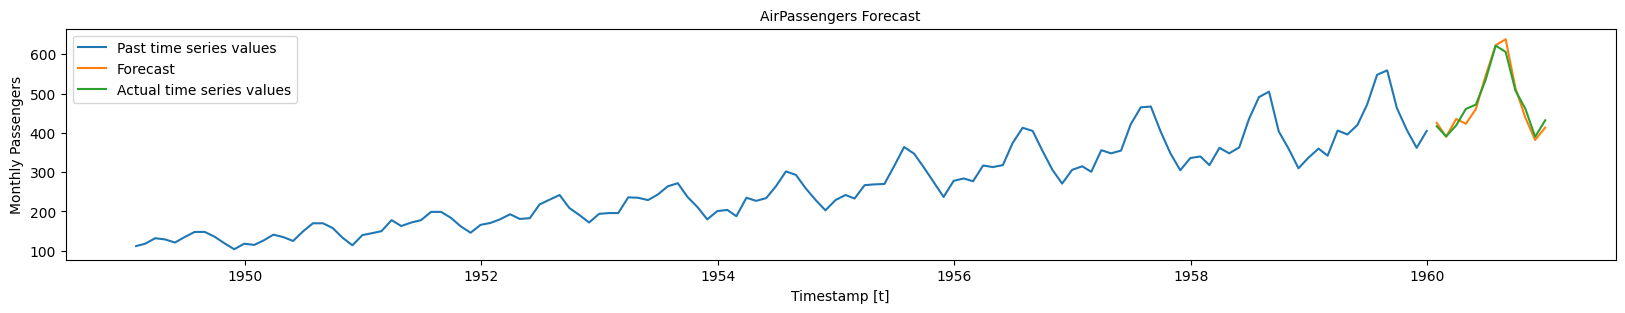

In [ ]:
Y_train_df.set_index('ds',inplace =True)
#Y_hat_df.set_index('ds',inplace =True)
Y_test_df.set_index('ds',inplace =True)

plt.figure(figsize=(20, 3))

y_past = Y_train_df["y"]
y_pred = Y_test_df['iTransformers']
y_test = Y_test_df["y"]

plt.plot(y_past, label="Past time series values")
plt.plot(y_pred, label="Forecast")
plt.plot(y_test, label="Actual time series values")
plt.title('AirPassengers Forecast', fontsize=10)
plt.ylabel('Monthly Passengers', fontsize=10)
plt.xlabel('Timestamp [t]', fontsize=10)

plt.legend();